## V.1 Exploring the green reds

In [384]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

import warnings        # used to remote warning messages
warnings.filterwarnings(action='once')

import datetime as dt  # used to give a filename of a figure being saved
import random as rd    # used to initialize weights
import itertools as it # used to create infinite counter in Perceptron.fit()
import math            # used to check for float equality in linspace
plt.tight_layout()
# %config InlineBackend.figure_format='svg'
%matplotlib inline

In [28]:
# load data with proper data tyles
df = pd.read_csv('resources/winequality-red.csv', delimiter=';', dtype=pd.np.float32)
df['quality'] = df['quality'].astype(pd.np.int16)

In [29]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float32
volatile acidity        1599 non-null float32
citric acid             1599 non-null float32
residual sugar          1599 non-null float32
chlorides               1599 non-null float32
free sulfur dioxide     1599 non-null float32
total sulfur dioxide    1599 non-null float32
density                 1599 non-null float32
pH                      1599 non-null float32
sulphates               1599 non-null float32
alcohol                 1599 non-null float32
quality                 1599 non-null int16
dtypes: float32(11), int16(1)
memory usage: 71.9 KB


**a) scatter matrix**

In [1018]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False, remove_neutral=False):
    side = wine_data.shape[1]  # calculate side of a scatter matrix
    if 'quality' not in wine_data.columns:
        raise ValueError("Wine dataset must contain quality feature")
    # C1 for bad, C2 for good, C3 for neutral
    data = wine_data.query('quality <= {} | quality >= {}'.format(bad_threshold, good_threshold)) if remove_neutral else wine_data
    qual_color = data['quality'].apply(lambda x: 'C3' if x <= bad_threshold else ('C2' if x >= good_threshold else 'C1'))    
    fig, axis = plt.subplots(side, side, figsize=(20, 20))
    fig.subplots_adjust(hspace=0, wspace=0)  # to remove gaps between plots
    plot_kw = {"s": 15, "alpha":.5}  # config for each plot
    for ax in axis.ravel():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            if i != j:  # create scatterplot
                axis[i, j].scatter(y=data.iloc[:, i], x=data.iloc[:, j], c=qual_color, **plot_kw)
            else:
                axis[i, j].text(0.5, 0.5, data.columns[i],
                                horizontalalignment='center', verticalalignment='center',
                                fontsize=15)
                
    from matplotlib.patches import Patch  # to create legend artists manually
    legend_elems = [Patch([0], [0], color='C3', label='bad wine'),
                    Patch([0], [0], color='C2', label='good wine')]
    if not remove_neutral:
        legend_elems.append(Patch([0], [0], color='C1', label='neutral wine'))
    fig.legend(handles=legend_elems)
    if save_plot:
        plt.savefig('scatter_matrix_{}.png'.format(str(dt.datetime.now())[:-7]))

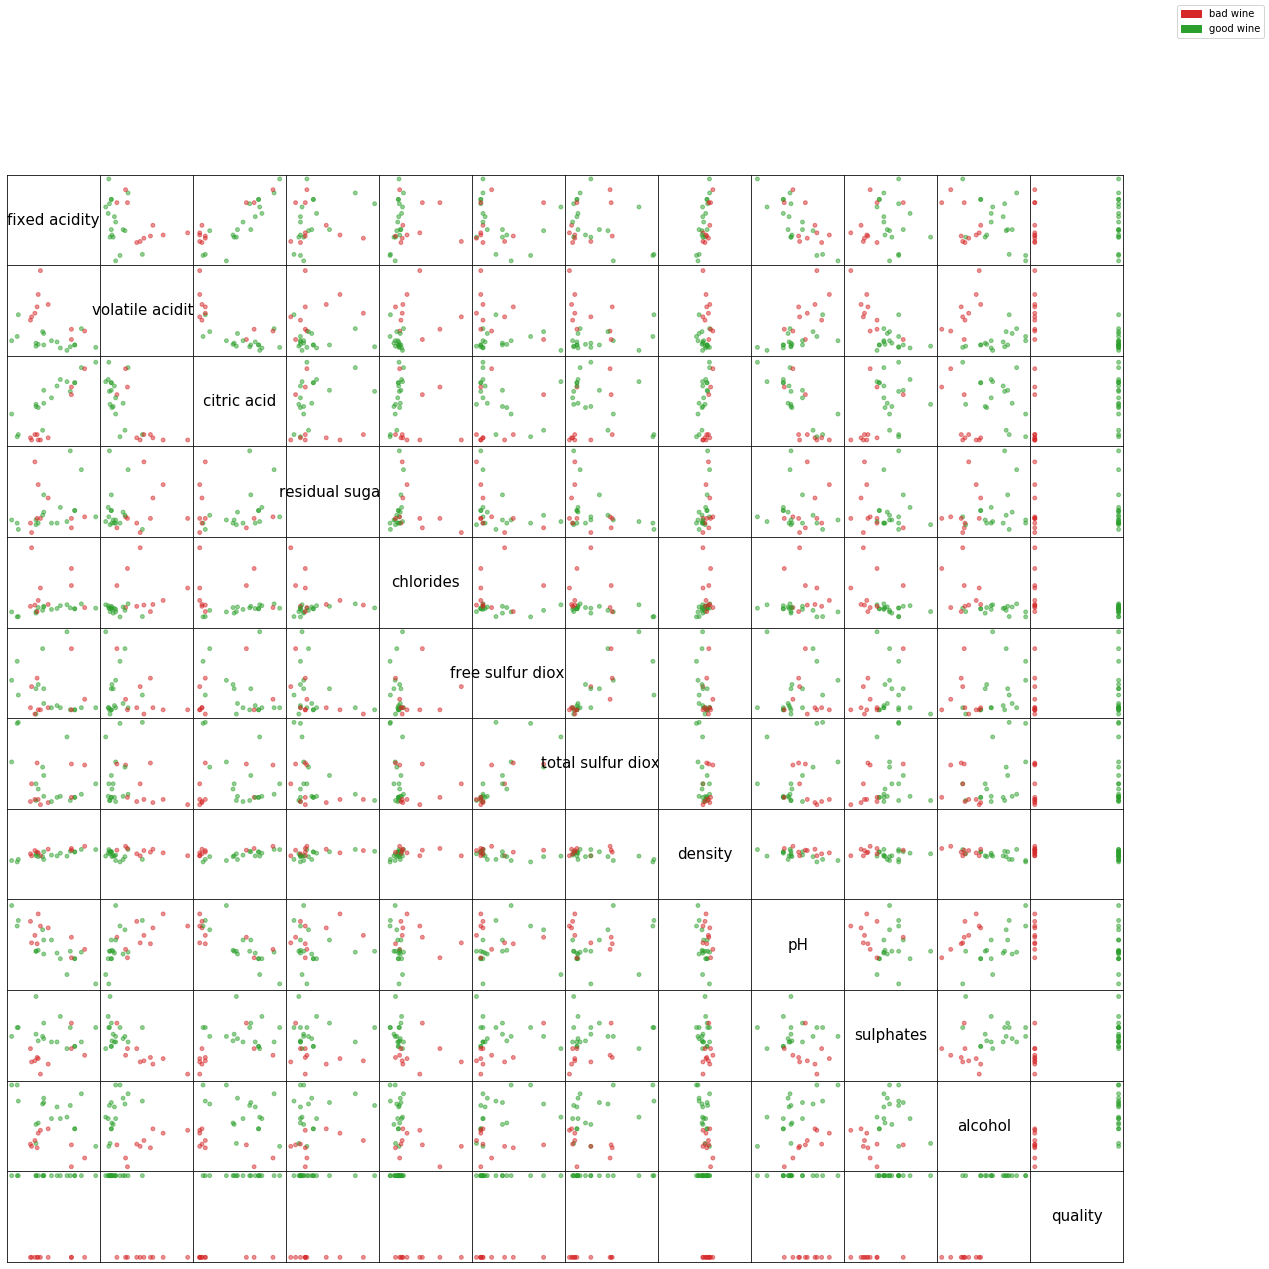

In [1021]:
plot_scatter_matrix(df, 8, 3, save_plot=False, remove_neutral=True)

**b) > Which factors will be most useful for perceptron to distinguish good wine (quality >= 8) from bad one (quality <= 3)?**
<br/>
<br />
Any pair of features will give a decent linear decision boundary. Most useful, when looking at scatter matrix, are `volatile acidity`, `alcohol`, `density`, `pH`, and `suplhates`.

## V.2 Learning to perceptron
<br />

**a) Perceptron implementation**

In [631]:
# first we create a basic class-interface to be specialized later
class Model:
    def __init__(self):
        """
        Base class for learning models
        """
        pass
    
    def __str__(self):
        return self.__class__.__name__
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass

In [887]:
class Perceptron(Model):
    def __init__(self, alpha=.01, activation_function='heaviside'):
        super().__init__()
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.activation_function = activation_function
        self.performance = []
    
    def fit(self, X, y, epochs=0):
        """
        Fit perceptron
        
        This function will infer input shape, initialize weights appropriatedly
        and fit model's parameters to data so as to minimize cost function.
        @param X: dataset of shape (n_samples, n_features)
        @param y: target values of shape (n_samples,)
        @param epochs: # of iterations over a dataset. If epochs=0, update weights
                       until no classification error made (unless non-separable classes)
        """
        if epochs < 0:
            raise ValueError("epochs >= 0")
        if X.shape[0] != y.shape[0]:
            raise ValueError("number of samples in X must equal to y")
        self._init_weights(X.shape[1])  # initialize weights using # of features
        last_n_errors = 0
        cnt_same_errors = 0
        for epoch in (range(epochs) if epochs > 0 else it.count()):
            n_errors = 0
            for (i, x), y_true in zip(X.iterrows(), y):
                y_pred = sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias) >= 0
                if abs(y_true - y_pred) == 0:  # no error - skip update
                    continue
                n_errors += 1
                for j in range(len(self.weights)):
                    self.weights[j] += self.alpha * (y_true - y_pred) * x[j]
                self.bias += self.alpha * (y_true - y_pred)
            self.performance.append((epoch, n_errors, self.weights, self.bias))
            if n_errors == 0:
                warnings.warn("Zero classification errors. Early stopping...")
                break
            if n_errors == last_n_errors:
                cnt_same_errors += 1
            else:
                last_n_errors = n_errors
                cnt_same_errors = 0
            if cnt_same_errors > 100:
                warnings.warn("Linearly non-separable classes suspected. Stopping...")
                break
    
    def predict(self, X):
        """
        Predict class label, given data
        """
        if self.bias is None or self.weights is None:
            raise ValueError("Fit perceptron to data before using it for prediction")
        y = []
        for i, x in X.iterrows():
            y.append(sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias) >= 0)
        return pd.Series(y, index=X.index).map(lambda x: 1 if x is True else 0)
    
    def _init_weights(self, shape):
        self.weights = [rd.gauss(0, 1) / 100 for _ in range(shape)]
        self.bias = 1
        

**b) Train Perceptron**

In [1029]:
def train_perceptron(data, learning_rate=.01, epochs=0):
    """
    Train Perceptron model and return it's performance
    
    @param data: pd.DataFrame that has training data and target feature as a last column
    """
    if 'quality' not in data.columns:
        raise ValueError("<data> must contain target column `quality`")
    p = Perceptron(learning_rate)
    X = data.loc[:, [col for col in data.columns if col not in ['quality', 'pred']]]
    y = data['quality']
    p.fit(X, y, epochs)
    return p.performance

**c) Plot model performance**

In [859]:
# some tools needed to plot the decision boundary
def linspace(start, stop, n_steps=100):
    """
    Return list of evenly-spaced values in interval [start, stop]
    """
    l = []
    step = (stop - start)/(n_steps - 1)
    for _ in range(n_steps - 1):
        l.append(start)
        start += step
    l.append(stop)
    return l

predict = lambda x, weights, bias: int(sum([w * x_j for w, x_j in zip(weights, x)], bias) >= 0)

In [881]:
def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    """
    Plot the performance of Perceptron or ADALINE.
    This function, given performance of a model, will produce a two-plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    
    Note:
    decision boundary is calculated at the end of <epoch>. Hence, number of classification
    errors can differ from what is observed on the plot, because weights are updated after
    each error separatedly (truly on-line algorithm), and not at the end.

    @param performance: list of (epoch, classification errors, weights, bias)-tuples
    @param wine_data: dataset that was used to train perceptron
    @param good_thresh: threshold for wine to be considered good (inclusive)
    @param bad_thresh: threshold for wine to be considered bad (inclusive)
    @param epoch: plot decision boundary for specified epoch. If epoch < 0, plot for
                  the last epoch in <performance>
    @param save_plot: if True, save figure to file
    """
    if len(wine_data.columns) != 3 or 'quality' not in wine_data.columns:
        raise ValueError("Provide dataframe with 2 features and target (`quality`)")
    errors = [epoch[1] for epoch in performance]
    epochs = [epoch[0] for epoch in performance]
    fig, axis = plt.subplots(ncols=2, figsize=(16, 8))
    # classification errors
    axis[0].plot(epochs, errors, 'bo--')
    axis[0].set_title("Error as a function of epoch")
    axis[0].set_xlabel("epoch")
    axis[0].set_ylabel("classification errors")
    # decision boundary
    epoch, _, weights, bias = performance[-1 if epoch < 0 or epoch >= len(performance) else epoch]
    xlabel, ylabel = wine_data.columns[[0, 1]]
    # Firstly, plot scatterplot to use it's limits
    f = axis[1].scatter(wine_data[xlabel], wine_data[ylabel], c=wine_data.quality,
                           s=15, alpha=.7, cmap='PiYG')
    axis[1].set_title("Decision boundary on epoch: {}".format(epoch))
    axis[1].set_xlabel(xlabel)
    axis[1].set_ylabel(ylabel)
    x_min, x_max = f.axes.get_xlim()
    y_min, y_max = f.axes.get_ylim()
    # Generating meshgrid without numpy is pain in the arse...
    xx, yy = linspace(x_min, x_max, 500), linspace(y_min, y_max, 500)
    Z = pd.DataFrame([[predict((x, y), weights, bias) for x in xx] for y in yy])
    axis[1].contourf(xx, yy, Z, cmap='PiYG', alpha=.3)
    axis[1].contour(xx, yy, Z, levels=[0, 1], cmap='tab10')
    # add legend manually
    from matplotlib.lines import Line2D  # to create legend artists manually
    legend_elems = [Line2D([0], [0], lw=1, color='blue', label='Decision Boundary'),
                    Line2D([0], [0], marker='o', lw=0, color='C2', label='good wines'),
                    Line2D([0], [0], marker='o', lw=0, color='#c61d94', label='bad wines')]
    axis[1].legend(handles=legend_elems, loc='upper left')
    if save_plot:
        plt.savefig('performance_plot_{}.png'.format(str(dt.datetime.now())[:-7]))
    plt.show()

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Zero classification errors. Early stopping...
/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


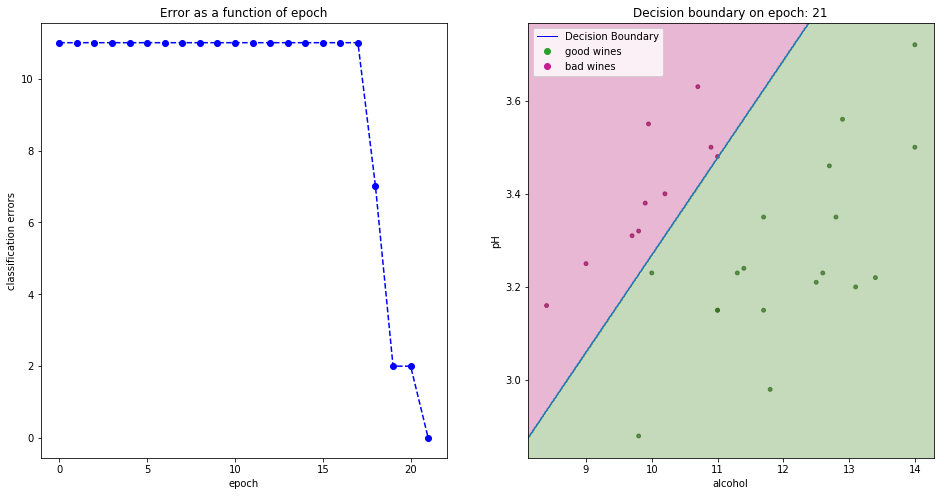

In [888]:
# extracting data
bad_threshold, good_threshold = 3, 8
small_df = df.query('quality <= {} | quality >= {}'.format(bad_threshold, good_threshold))[['alcohol', 'pH', 'quality']]
small_df['quality'] = small_df['quality'].map(lambda x: 0 if x <= bad_threshold else 1)
# train perceptron
perf = train_perceptron(small_df, epochs=500)
# plot performance
plot_performance(perf, small_df, good_threshold, bad_threshold, 1000, True)

**d) Feature Scaling**

In [636]:
# first, let's specialize model for transformers
class TransformerMixin(object):
    def fit_transform(self, X, y=None, **fit_params):
        """
        Fit to data, then transform it.
        """
        pass
    
    def transform(self, X):
        """
        Transform data, using fitted parameters
        """

In [963]:
class StandardScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Standard Scaler transforms each feature of X to have zero mean and unit variance:
        X = (X - μ) / σ
        
        Cons:
            * Assumes data is Normally-distributed
            * Small variance can lead to unstable results
        """
        super().__init__()
        self.mus = []
        self.sigmas = []

    def fit(self, X):
        """
        Estimate mean and standard deviation for each feature in <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            return X
        if len(X.shape) == 1:
            mu = sum(X)/X.shape[0]
            var = sum([math.pow(x - mu, 2) for x in X])/(X.shape[0] - 1)
            sigma = math.sqrt(var)
            self.mus.append(mu)
            self.sigmas.append(sigma)
        else:
            nrows, ncols = X.shape
            for i in range(ncols):
                mu = sum(X.iloc[:, i])/X.shape[0]
                var = sum([math.pow(x - mu, 2) for x in X.iloc[:, i]])/(X.shape[0] - 1)
                sigma = math.sqrt(var)
                self.mus.append(mu)
                self.sigmas.append(sigma)

    def fit_transform(self, X):
        """

        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted sample mean and standard deviation to transform <X>
        """
        if len(self.mus) == 0 or len(self.sigmas) == 0 or len(self.mus) != len(self.sigmas):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            mu = self.mus[0]
            sigma = self.sigmas[0]
            if sigma == 0 or (mu == 0 and sigma == 1):
                return X.copy()
            return X.apply(lambda x: (x - mu)/sigma)
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, mu, sigma in zip(range(ncols), self.mus, self.sigmas):
            if (mu == 0 and sigma == 1) or sigma == 0:
                continue
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - mu)/sigma)
        return Xc
    
    def _reset_estimates(self):
        self.mus = []
        self.sigmas = []


In [952]:
class MinMaxScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Min-Max scaling transforms every feature of <X> in [0, 1] range:
        X = (X - min(X))/(max(X) - min(X))
        
        Cons:
            * Suppresses outliers
            * May result in underflow
        Notes:
            It doesn't really matter if one fits estimates on train data,
            and then uses it to scale test dataset as a part of preprocessing
            pipeline. If you really need to remove the possibility of transformed
            data to be outside of [0, 1], use scaling range algorithm.
        """
        super().__init__()
        self.mins = []
        self.maxs = []

    def fit(self, X):
        """
        Calculate min and max for each feature of <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            warnings.warn("X is too small to require scaling")
            return X
        if len(X.shape) == 1:
            self.mins.append(min(X))
            self.maxs.append(max(X))
        else:
            for i in range(X.shape[1]):
                self.mins.append(min(X.iloc[:, i]))
                self.maxs.append(max(X.iloc[:, i]))

    def fit_transform(self, X):
        """
        Fit estimates for <X> and use them for transformation
        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted min and max of every feature to transform <X>
        """
        if len(self.mins) == 0 or len(self.maxs) == 0 or len(self.mins) != len(self.maxs):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if any([min == max for min, max in zip(self.mins, self.maxs)]):
            warnings.warn("min(X) == max(x): MinMax Scaling is not applicable")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            min = self.mins[0]
            max = self.maxs[0]
            if min == 0 and max == 1:
                return X.copy()
            return X.apply(lambda x: (x - min)/(max - min))
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, min, max in zip(range(ncols), self.mins, self.maxs):
            if min == 0 and max == 1:
                continue
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - min)/(max - min))
        return Xc
    
    def _reset_estimates(self):
        self.mins = []
        self.maxs = []

In [1001]:
class RobustScaler(Model, TransformerMixin):
    def __init__(self):
        """
        Robust Scaler is similar to MinMaxScaler, but uses first and third quantiles
        instead of min/max:
        X = (X - Q1(X))/IQR(X)
        
        Cons:
            * Uses less data for actual scaling
        Notes:
            Using quantiles makes it resilient to outliers
        """
        super().__init__()
        self.q1s = []
        self.q3s = []

    def fit(self, X):
        """
        Calculate min and max for each feature of <X>
        """
        self._reset_estimates()
        if X.shape[0] < 2:
            warnings.warn("X is too small to require scaling")
            return X
        if len(X.shape) == 1:
            self.q1s.append(X.quantile(.25))
            self.q3s.append(X.quantile(.75))
        else:
            for i in range(X.shape[1]):
                self.q1s.append(X.iloc[:, i].quantile(.25))
                self.q3s.append(X.iloc[:, i].quantile(.75))

    def fit_transform(self, X):
        """
        Fit estimates for <X> and use them for transformation
        @param X: pd.DataFrame or pd.Series
        @return: Transformed copy of X
        """
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        """
        Use fitted min and max of every feature to transform <X>
        """
        if len(self.q1s) == 0 or len(self.q3s) == 0 or len(self.q1s) != len(self.q3s):
            warnings.warn("Either fit wasn't called of X is too small")
            return X
        if any([q1 == q3 for q1, q3 in zip(self.q1s, self.q3s)]):
            warnings.warn("Q1(X) == Q3(x): Robust Scaling is not applicable")
            return X
        if len(X.shape) == 1:  # pd.Series doesn't have second dimension
            q1 = self.q1s[0]
            q3 = self.q3s[0]
            return X.apply(lambda x: (x - q1)/(q3 - q1))
        nrows, ncols = X.shape
        Xc = X.copy()  # copy is returned to avoid changing input dataset
        for i, q1, q3 in zip(range(ncols), self.q1s, self.q3s):
            Xc.iloc[:, i] = Xc.iloc[:, i].apply(lambda x: (x - q1)/(q3 - q1))
        return Xc
    
    def _reset_estimates(self):
        self.q1s = []
        self.q3s = []

/Users/ptyshevs/envs/loc_env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


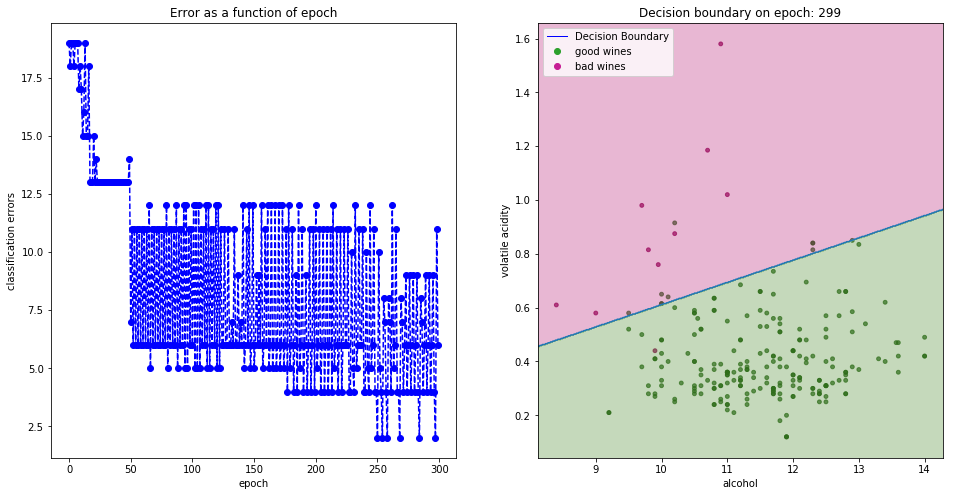

In [1002]:
rd.seed(42)  # set seed for reproducibility
bad_threshold, good_threshold = 3, 7
df_raw = df.query('quality <= {} | quality >= {}'.format(bad_threshold, good_threshold))[['alcohol', 'volatile acidity', 'quality']]
df_raw['quality'] = df_raw['quality'].map(lambda x: 0 if x <= bad_threshold else 1)
# train perceptron
raw_perf = train_perceptron(df_raw, epochs=300)
plot_performance(raw_perf, df_raw, good_threshold, bad_threshold, -1, False)

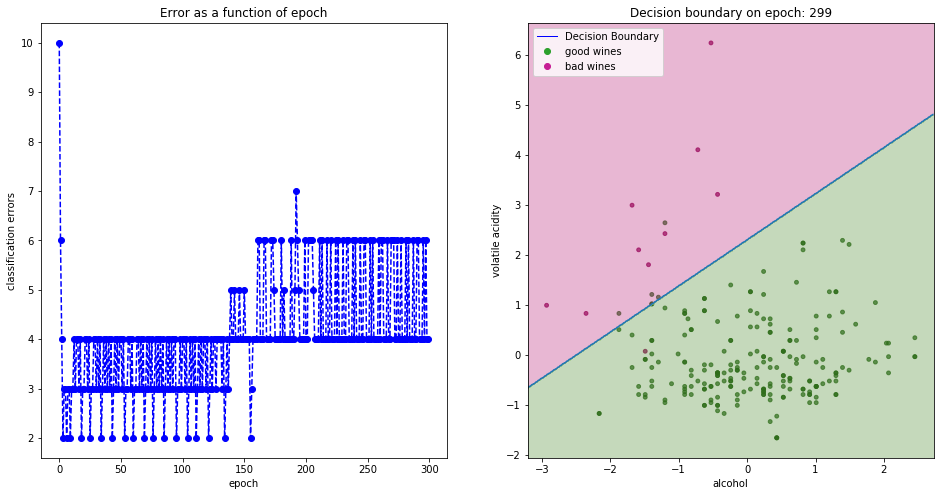

In [1003]:
# apply standard scaling for all features from `df_raw`, expect for the target
df_norm = StandardScaler().fit_transform(df_raw[[col for col in df_raw.columns if col != 'quality']])
df_norm = pd.concat([df_norm, df_raw['quality']], axis=1)
norm_perf = train_perceptron(df_norm, epochs=300)
plot_performance(norm_perf, df_norm, good_threshold, bad_threshold, -1, False)

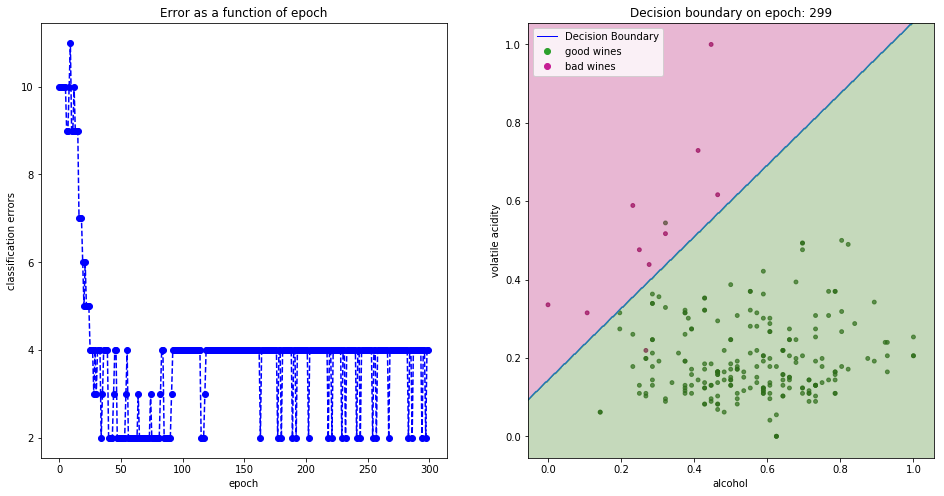

In [1004]:
# apply minmax scaling for all features from `df_raw`, except for the target
df_mm = MinMaxScaler().fit_transform(df_raw[[col for col in df_raw.columns if col != 'quality']])
df_mm = pd.concat([df_mm, df_raw['quality']], axis=1)
mm_perf = train_perceptron(df_mm, epochs=300)
plot_performance(mm_perf, df_mm, good_threshold, bad_threshold, -1, False)

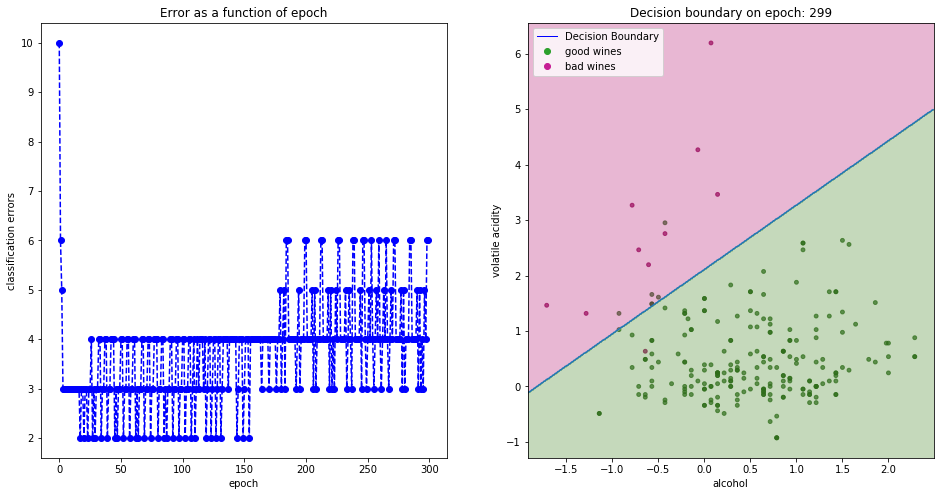

In [1005]:
# apply robust (IQR) scaling for all features from `df_raw`, except for the target
df_rob = RobustScaler().fit_transform(df_raw[[col for col in df_raw.columns if col != 'quality']])
df_rob = pd.concat([df_rob, df_raw['quality']], axis=1)
rob_perf = train_perceptron(df_rob, epochs=300)
plot_performance(rob_perf, df_rob, good_threshold, bad_threshold, -1, False)

## V.3 ADALINE

<br />

**a) Perceptron for binary classification: `quality <= 4` as bad and `quality >= 7` as good. Why it's not a good idea?**

As shown below, the decision boundary for this pair of features is very unstable. Perceptron keeps misclassifying the same samples, hence we see a distinctive pattern on plot 1. If we further look at decision boundary plot, we see many observations of opposite classes being intertwined.

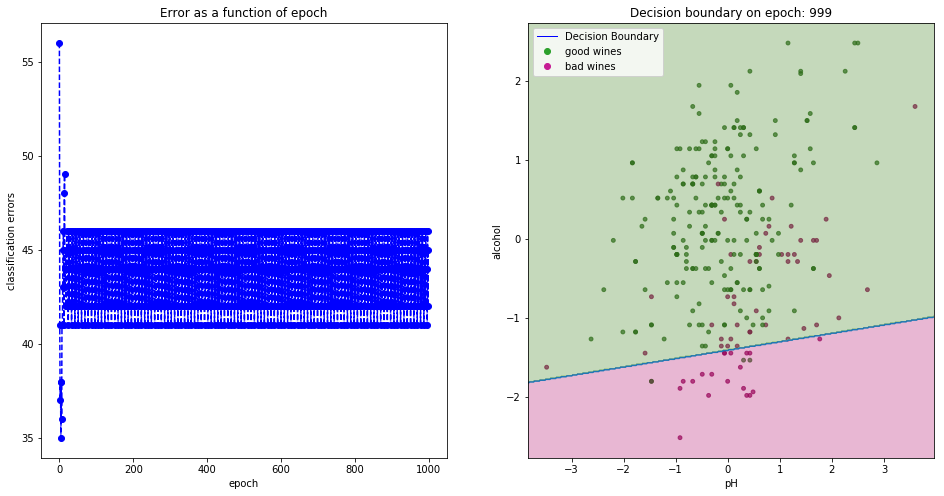

In [1026]:
df_nonsep = df.query('quality <= 4 | quality >= 7')[['alcohol', 'pH', 'quality']]
df_nonsep.quality = df_nonsep.quality.map(lambda x: 0 if x <= 4 else 1)
X = StandardScaler().fit_transform(df_nonsep[['pH', 'alcohol']])
train_df = pd.concat([X, df_nonsep['quality']], axis=1)
nonsep_perf = train_perceptron(train_df, epochs=1000)
plot_performance(nonsep_perf, train_df, 7, 4, -1, False)

**b) ADALINE implementation**

In [1028]:
class Adaline(Model):
    def __init__(self, alpha=.01, activation_function='sgn'):
        super().__init__()
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.activation_function = activation_function
        self.performance = []
    
    def fit(self, X, y, epochs=0):
        """
        Fit perceptron
        
        This function will infer input shape, initialize weights appropriatedly
        and fit model's parameters to data so as to minimize cost function.
        @param X: dataset of shape (n_samples, n_features)
        @param y: target values of shape (n_samples,)
        @param epochs: # of iterations over a dataset. If epochs=0, update weights
                       until no classification error made (unless non-separable classes)
        """
        if epochs < 0:
            raise ValueError("epochs >= 0")
        if X.shape[0] != y.shape[0]:
            raise ValueError("number of samples in X must equal to y")
        self._init_weights(X.shape[1])  # initialize weights using # of features
        last_n_errors = 0
        cnt_same_errors = 0
        for epoch in (range(epochs) if epochs > 0 else it.count()):
            n_errors = 0
            for (i, x), y_true in zip(X.iterrows(), y):
                y_pred = sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias)
                if abs(y_true - self._activation(y_pred)) == 0:  # no error - skip update
                    continue
                n_errors += 1
                for j in range(len(self.weights)):
                    self.weights[j] += self.alpha * (y_true - y_pred) * x[j]
                self.bias += self.alpha * (y_true - y_pred)
            self.performance.append((epoch, n_errors, self.weights, self.bias))
            if n_errors == 0:
                warnings.warn("Zero classification errors. Early stopping...")
                break
            if n_errors == last_n_errors:
                cnt_same_errors += 1
            else:
                last_n_errors = n_errors
                cnt_same_errors = 0
            if cnt_same_errors > 100:
                warnings.warn("Linearly non-separable classes suspected. Stopping...")
                break
    
    def _activation(self, z):
        if self.activation_function == 'sgn':
            return 1 if z >= 0 else 0
    
    def predict(self, X):
        """
        Predict class label, given data
        """
        if self.bias is None or self.weights is None:
            raise ValueError("Fit {} to data before using it for prediction".format(str(self)))
        y = []
        for i, x in X.iterrows():
            y.append(sum([w * x_j for w, x_j in zip(self.weights, x)], self.bias) >= 0)
        return pd.Series(y, index=X.index).map(lambda x: 1 if x is True else 0)
    
    def _init_weights(self, shape):
        self.weights = [rd.gauss(0, 1) / 100 for _ in range(shape)]
        self.bias = 1

In [ ]:
def train_adaline(data, learning_rate=.01, epochs=0):
    """
    Train Adaline model and return it's performance
    
    @param data: pd.DataFrame that has training data and target feature as a last column
    """
    if 'quality' not in data.columns:
        raise ValueError("<data> must contain target column `quality`")
    p = Perceptron(learning_rate)
    X = data.loc[:, [col for col in data.columns if col != 'quality']]
    y = data['quality']
    p.fit(X, y, epochs)
    return p.performance